# Swissmetro test

In [1]:
import dill as pickle
import pycmtensor as cmt
from pycmtensor.models import MNLogit
from pycmtensor.optimizers import Adam
from pycmtensor.expressions import Beta, Weights
from pycmtensor.results import Results, Predict

cmt.logger.set_level(cmt.logger.WARNING)


In [2]:
import pycmtensor as cmt
import pandas as pd
swissmetro = pd.read_csv("data/swissmetro.dat", sep="\t")
db = cmt.Database(name="swissmetro", pandasDatabase=swissmetro, choiceVar="CHOICE")
globals().update(db.variables)
# Removing some observations
exclude = ((PURPOSE != 1) * (PURPOSE != 3) + (CHOICE == 0)) > 0
db.remove(exclude)

# additional steps to format database
db.data["CHOICE"] -= 1  # set the first choice to 0
db.choices = sorted(db.data["CHOICE"].unique())  # save original choices
db.autoscale(
    variables=["TRAIN_CO", "TRAIN_TT", "CAR_CO", "CAR_TT", "SM_CO", "SM_TT"],
    default=100.0,
    verbose=False,
)

In [3]:
# declare model params here
b_cost = Beta("b_cost", 0.0, None, None, 0)
b_time = Beta("b_time", 0.0, None, None, 0)
b_dist = Beta("b_dist", 0.0, None, None, 0)
asc_train = Beta("asc_train", 0.0, None, None, 0)
asc_car = Beta("asc_car", 0.0, None, None, 0)
asc_sm = Beta("asc_sm", 0.0, None, None, 1)

U_1 = b_cost * db["TRAIN_CO"] + b_time * db["TRAIN_TT"] + asc_train
U_2 = b_cost * db["SM_CO"] + b_time * db["SM_TT"] + asc_sm
U_3 = b_cost * db["CAR_CO"] + b_time * db["CAR_TT"] + asc_car

# specify the utility function and the availability conditions
U = [U_1, U_2, U_3]
AV = [db["TRAIN_AV"], db["SM_AV"], db["CAR_AV"]]

mymodel = MNLogit(u=U, av=AV, database=db, name="mymodel")
mymodel.add_params(locals())

# set training configuration
mymodel.config["patience"] = 20000
mymodel.config["base_lr"] = 0.0012
mymodel.config["max_lr"] = 0.002
mymodel.config["batch_size"] = 128
mymodel.config["max_epoch"] = 10
mymodel.config["learning_scheduler"] = "CyclicLR"
mymodel.config["cyclic_lr_step_size"] = 8
mymodel.config["cyclic_lr_mode"] = "triangular2"

[2022-03-17 16:24:12] WARNING: Unused Betas removed from computational graph: {b_dist}. To keep Betas in model, set Beta.status=1


In [4]:
# train function
model = cmt.train(mymodel, database=db, optimizer=Adam, notebook=True)

# with open("myModel.pkl", "rb") as f:
#     model = pickle.load(f)

result = Results(model, db, show_weights=True)
result.print_beta_statistics()
result.print_correlation_matrix()


[2022-03-17 16:24:29] WARNING: max_epoch=10 is smaller than expected value =384, setting default max_epoch=384.


dataset: swissmetro (n=6768)
batch size: 128
iterations per epoch: 52


Loglikelihood:  -6964.663  Score: 0.134

Epoch    0/19968:   0%|          | 0.00/20.0k [00:00<?, ?it/s]

Optimization complete with accuracy of 62.736%. Max loglikelihood reached @ epoch 290.

Results for model: mymodel
Build time: 00:00:16
Estimation time: 00:00:35
Estimation rate: 563.555 iter/s
Seed value: 4171
Number of Beta parameters: 4
Sample size: 6768
Excluded data: 3960
Init loglikelihood: -6964.663
Final loglikelihood: -5590.522
Final loglikelihood reached at: epoch 290
Likelihood ratio test: 2748.282
Accuracy: 62.736%
Rho square: 0.197
Rho bar square: 0.197
Akaike Information Criterion: 11189.04
Bayesian Information Criterion: 11216.32
Final gradient norm: 0.231

Statistical Analysis:
              Value   Std err     t-test   p-value Rob. Std err Rob. t-test Rob. p-value
asc_car    0.113123  0.042132   2.684983  0.007253     0.041984    2.694453      0.00705
asc_train -0.547701  0.054128 -10.118625       0.0     0.065402   -8.374422          0.0
b_cost      0.01843  0.002914    6.32488       0.0     0.013566    1.358568     0.174284
b_time    -1.136592   0.05369 -21.169638   

<Figure size 432x288 with 0 Axes>

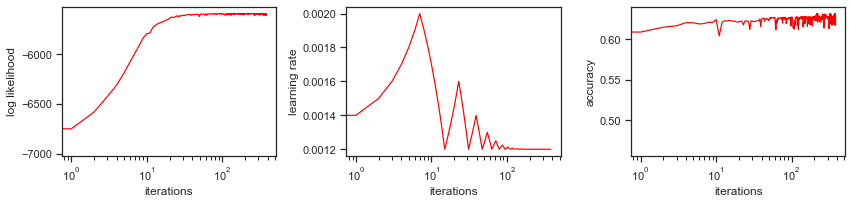

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("ticks")
sns.set_context("notebook", font_scale=1.0, rc={"lines.linewidth": 1.2})
sns.despine()
log = model.tracker.get_data()
fig, axs = plt.subplots(1, 3, figsize=(12, 3), squeeze=False)
g1 = sns.lineplot(ax=axs[0, 0], data=log, x=log.index, y="full_ll", color="red")
g2 = sns.lineplot(ax=axs[0, 1], data=log, x=log.index, y="lr", color="red")
g3 = sns.lineplot(
    ax=axs[0, 2], data=log, x=log.index, y="score", color="red"
)  # y = score or full_ll or lr
g1.set(xscale="log", xlabel="iterations", ylabel="log likelihood")
g2.set(xscale="log", xlabel="iterations", ylabel="learning rate")
g3.set(xscale="log", xlabel="iterations", ylabel="accuracy")
plt.tight_layout()
plt.savefig("docs/viz/fig.png", format="png", facecolor="white", transparent=False)
plt.show()


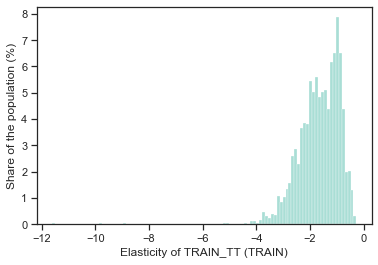

In [22]:
e = model.elasticities(prob_choice=0, wrt="TRAIN_TT", database=db)
e1 = sns.histplot(e, stat="percent")
e1.set(xlabel="Elasticity of TRAIN_TT (TRAIN)", ylabel="Share of the population (%)")
plt.savefig("docs/viz/els.png", format="png", facecolor="white", transparent=False)
plt.show()

In [7]:
from pycmtensor.results import Predict
import pandas as pd
# with open("myModel.pkl", "rb") as f:
#     model = pickle.load(f)

pd.concat((Predict(model, db).probs(), Predict(model, db).choices()), axis=1)


,0,1,2,CHOICE
0,0.170780,0.515813,0.313407,1
1,0.182409,0.514333,0.303259,1
2,0.147241,0.522000,0.330759,1
3,0.154057,0.420681,0.425262,2
4,0.128445,0.476192,0.395363,1
...,...,...,...,...
6763,0.170419,0.570164,0.259417,1
6764,0.144320,0.466658,0.389022,1
6765,0.142271,0.475640,0.382089,1
6766,0.118307,0.479918,0.401775,1


The output file is available at docs/viz/print.png


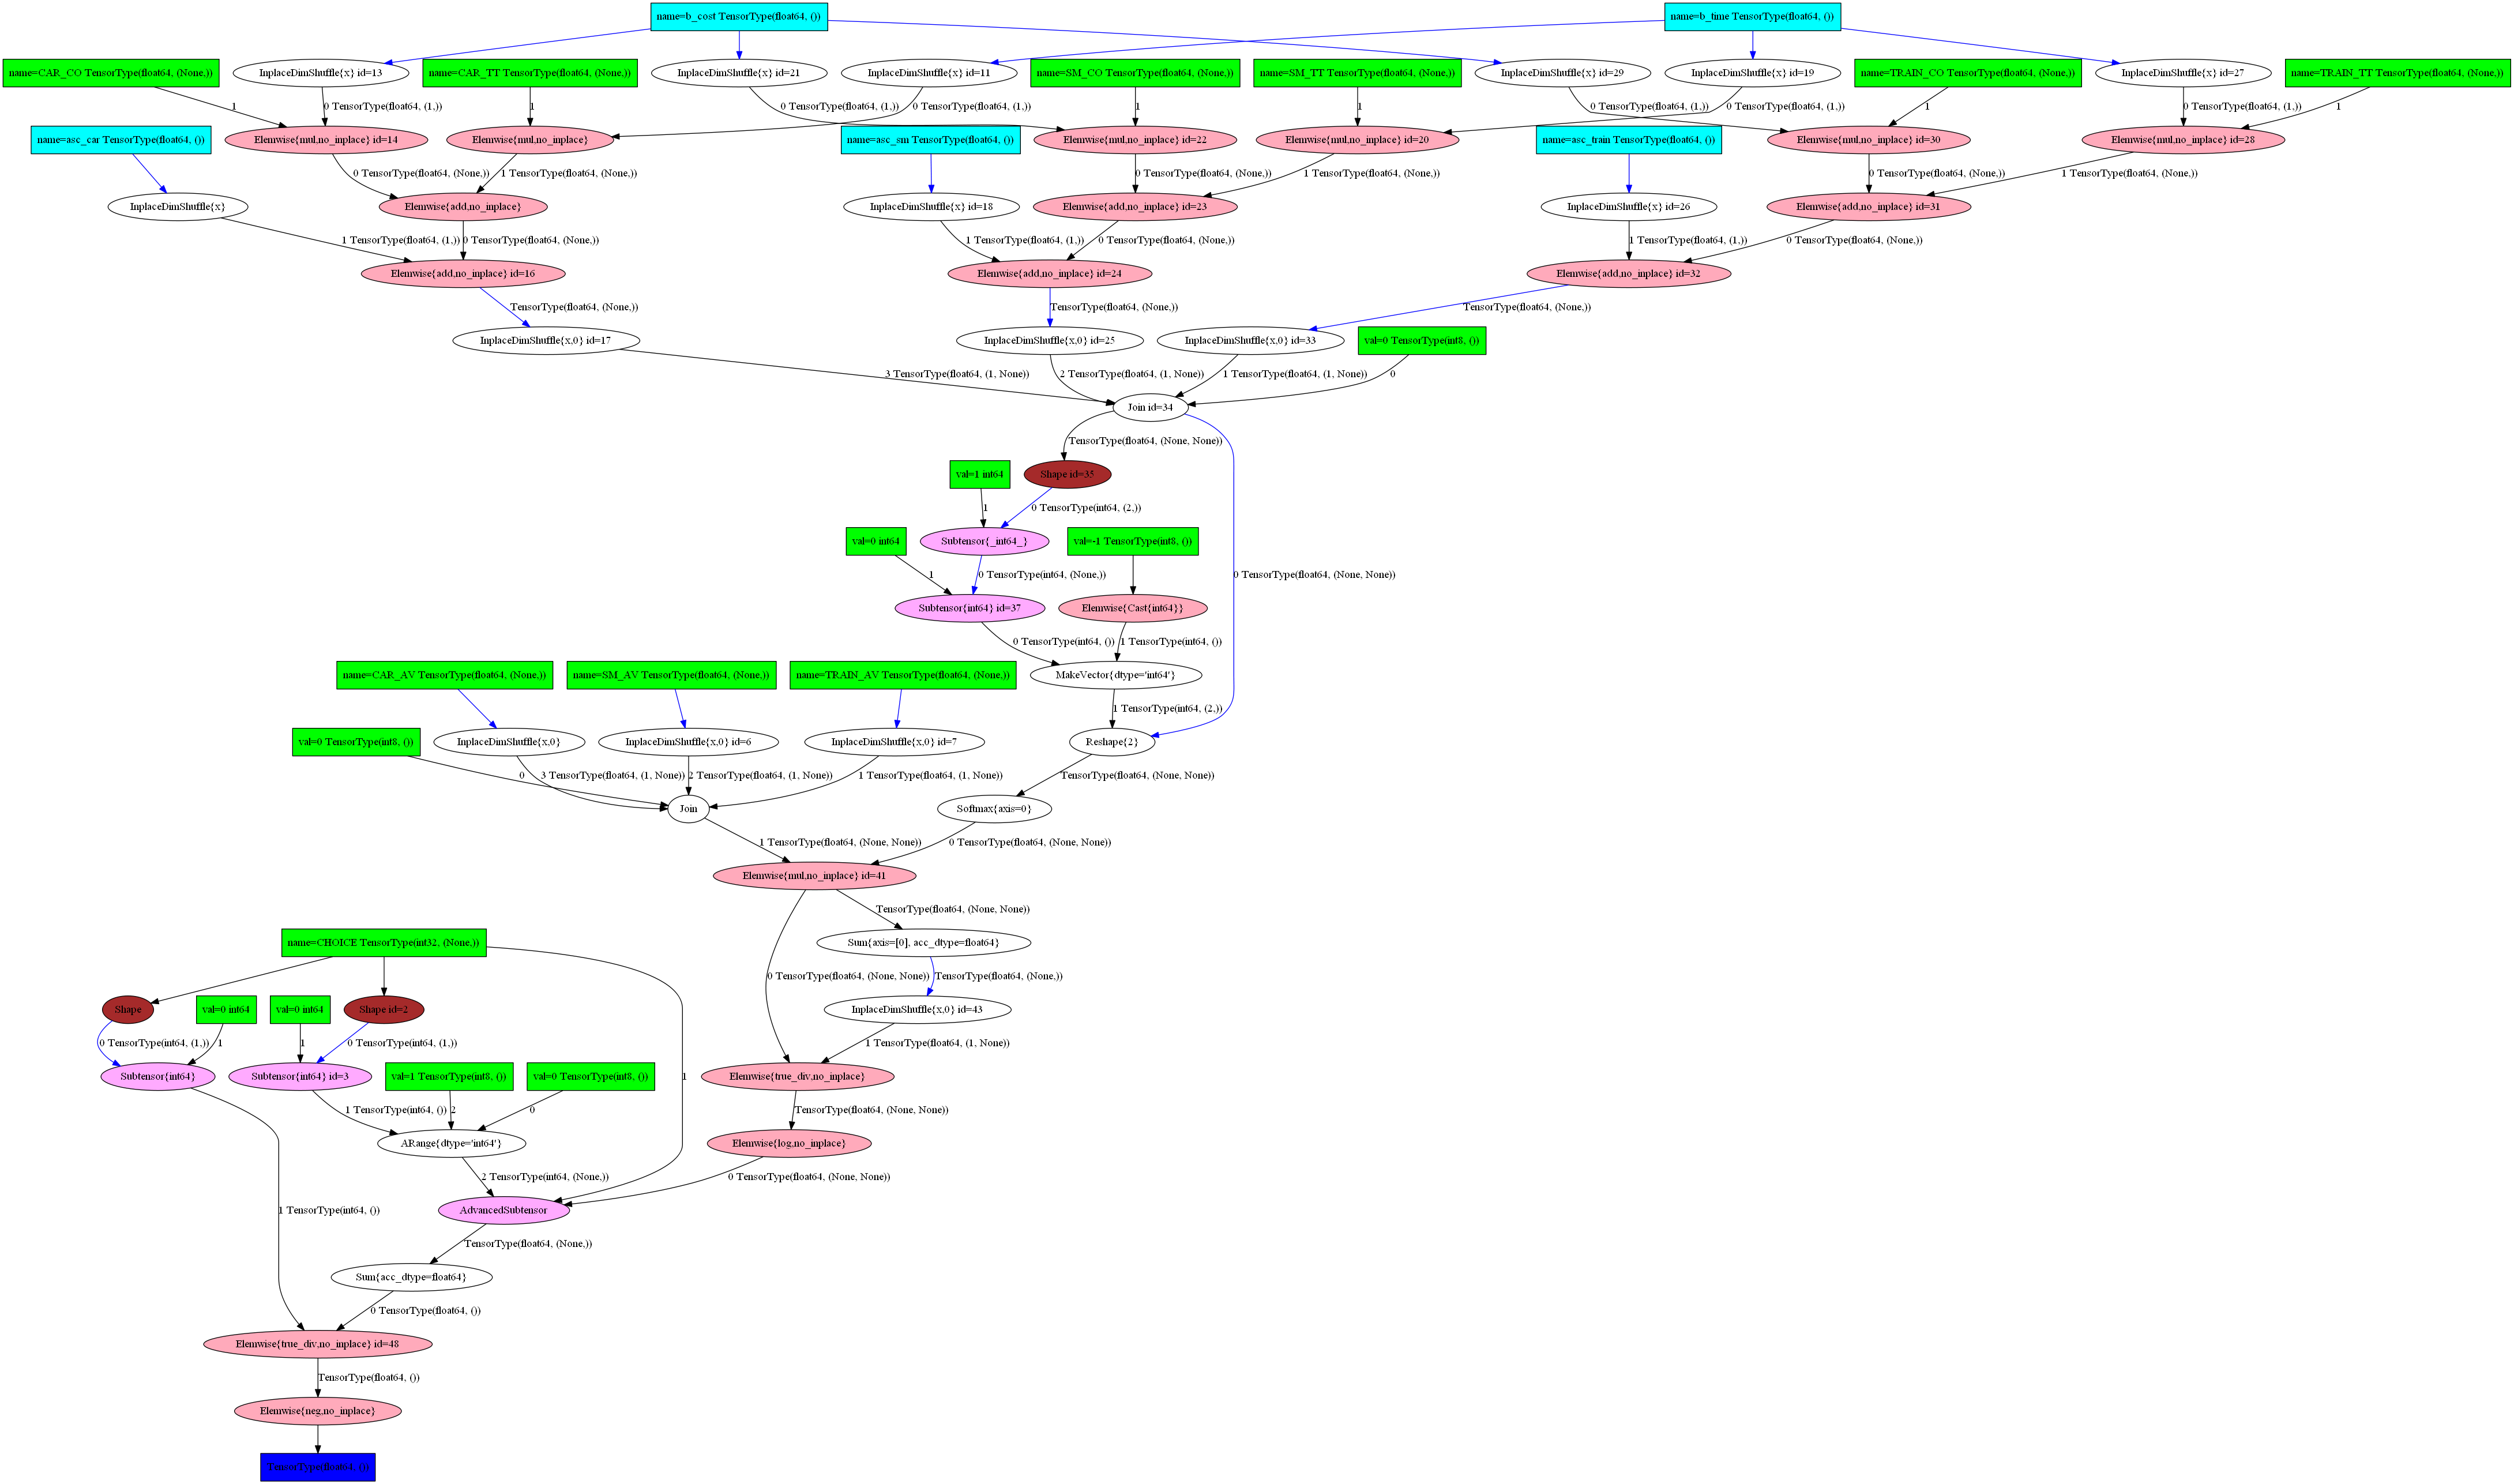

In [8]:
import aesara.d3viz as d3v
from aesara import printing

d3v.d3viz(model.loglikelihood, "docs/viz/MNLogit.html")

printing.pydotprint(mymodel.cost, "docs/viz/print.png")
from IPython.display import Image

Image("docs/viz/print.png", width="80%")
